In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:

import pandas as pd
from PIL import Image
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader


In [ ]:
from __future__ import print_function, division

import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import numpy as np
import time
import copy

In [ ]:
 # Directory with our gorillas_testing_data_2 for training
train_dir = os.path.join('/content/gdrive/MyDrive/GTVD-(DS440-Team1)/Data/Data_collection2/animal_statue_data/Benchmark_training') 

# Directory with our Gorillas_Validation for validation
valid_dir = os.path.join('/content/gdrive/MyDrive/GTVD-(DS440-Team1)/Data/Data_collection2/animal_statue_data/Benchmark_validation')

# Directory with our Gorillas_Testing for testing
test_dir = os.path.join('/content/gdrive/MyDrive/GTVD-(DS440-Team1)/Data/Data_collection2/animal_statue_data/Benchmark_testing')

In [ ]:
labels = os.listdir(train_dir)

# Initialize labels encoder
encoder_labels = LabelEncoder()
encoder_labels.fit(labels)

# Create lists of files and labels for training 
files_train = []
labels_train = []
for label in labels:
    for filename in os.listdir(train_dir + '/' + label ):
        files_train.append(train_dir + '/' + label + '/' + filename)
        labels_train.append(label)

# Create lists of files and labels for validation 
files_val = []
labels_val = []
for label in labels:
  for filename in os.listdir(valid_dir + '/' + label):
      files_val.append(valid_dir + '/' + label + '/' + filename)
      labels_val.append(label)

# List of files for testing 
files_test = []
labels_test = []
# for label in labels:
for filename in os.listdir(test_dir + '/' + 'Non_Violation'):
    files_test.append(test_dir + '/' + 'Non_Violation' + '/' + filename)
    files_test = sorted(files_test)
    labels_test.append('Non_Violation')
for filename in os.listdir(test_dir + '/' + 'Violation'):
    files_test.append(test_dir + '/' + 'Violation' + '/' + filename)
    files_test = sorted(files_test)
    labels_test.append('Violation')
print("The first five files from the list of train images:", files_train[:5])
print("\nThe first five labels from the list of train labels:", labels_train[:5])
print("\nThe first five files from the list of validation images:", files_val[:5])
print("\nThe first five labels from the list of validation labels:", labels_val[:5])
print("\nThe first five files from the list of test images:", files_test[:5])
print("\nThe first five labels from the list of test labels:", labels_test[:5])

The first five files from the list of train images: ['/content/gdrive/MyDrive/GTVD-(DS440-Team1)/Data/Data_collection2/animal_statue_data/Benchmark_training/Violation/IMG_2342.JPG', '/content/gdrive/MyDrive/GTVD-(DS440-Team1)/Data/Data_collection2/animal_statue_data/Benchmark_training/Violation/IMG_1802.JPG', '/content/gdrive/MyDrive/GTVD-(DS440-Team1)/Data/Data_collection2/animal_statue_data/Benchmark_training/Violation/IMG_5560.JPG', '/content/gdrive/MyDrive/GTVD-(DS440-Team1)/Data/Data_collection2/animal_statue_data/Benchmark_training/Violation/IMG_5642.JPG', '/content/gdrive/MyDrive/GTVD-(DS440-Team1)/Data/Data_collection2/animal_statue_data/Benchmark_training/Violation/IMG_2171.JPG']

The first five labels from the list of train labels: ['Violation', 'Violation', 'Violation', 'Violation', 'Violation']

The first five files from the list of validation images: ['/content/gdrive/MyDrive/GTVD-(DS440-Team1)/Data/Data_collection2/animal_statue_data/Benchmark_validation/Violation/IMG_262

In [ ]:
class ImagesDataset(Dataset):
    def __init__(self, files, labels, encoder, transforms, mode):
        super().__init__()
        self.files = files
        self.labels = labels
        self.encoder = encoder
        self.transforms = transforms
        self.mode = mode

    def __len__(self):
        return len(self.files)

    def __getitem__(self, index):
        pic = Image.open(self.files[index]).convert('RGB')

        if self.mode == 'train' or self.mode == 'val':
            x = self.transforms(pic)
            label = self.labels[index]
            y = self.encoder.transform([label])[0]
            return x, y
        elif self.mode == 'test':
            x = self.transforms(pic)
            return x, self.files[index]
        
transforms_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.4802, 0.4481, 0.3975], [0.2302, 0.2265, 0.2262]),
    transforms.RandomErasing(p=0.5, scale=(0.06, 0.08), ratio=(1, 3), value=0, inplace=True)
])

transforms_val = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.4802, 0.4481, 0.3975], [0.2302, 0.2265, 0.2262])
])

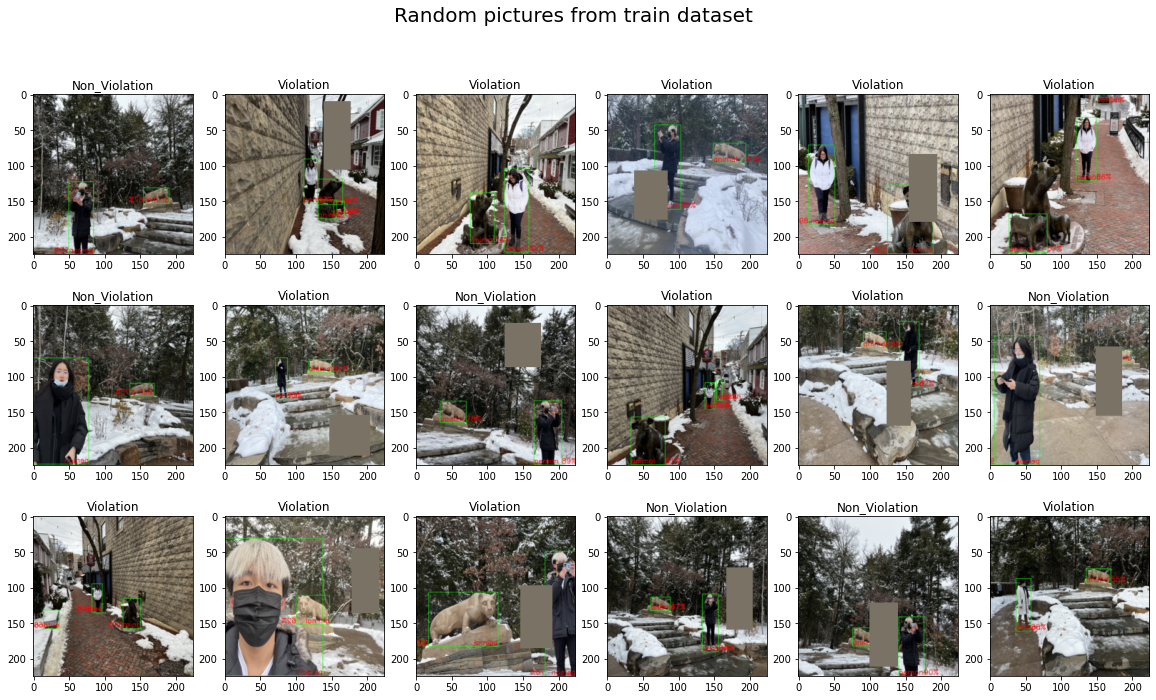

In [ ]:

train_dataset = ImagesDataset(files=files_train,
                              labels=labels_train,
                              encoder=encoder_labels,
                              transforms=transforms_train,
                              mode='train')

val_dataset = ImagesDataset(files=files_val,
                            labels=labels_val,
                            encoder=encoder_labels,
                            transforms=transforms_val,
                            mode='val')

test_dataset = ImagesDataset(files=files_test,
                             labels=None,
                             encoder=None,
                             transforms=transforms_val,
                             mode='test')

fig, axs = plt.subplots(3, 6, figsize=(20,11))
fig.suptitle('Random pictures from train dataset', fontsize=20)
for ax in axs.flatten():
    n = np.random.randint(len(train_dataset))
    img = train_dataset[n][0]
    img = img.numpy().transpose((1, 2, 0))
    mean = np.array([0.4802, 0.4481, 0.3975])
    std = np.array([0.2302, 0.2265, 0.2262])
    img = std * img + mean
    img = np.clip(img, 0, 1)
    ax.set_title(encoder_labels.inverse_transform([train_dataset[n][1]])[0])
    ax.imshow(img)

In [ ]:
print(len(train_dataset),len(val_dataset), len(test_dataset))

618 142 60


In [ ]:
print(labels)

['Violation', 'Non_Violation']


In [ ]:
def training(model, model_name, num_epochs, train_dataloader, val_dataloader):
    since = time.time()

    loss_function = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0003)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.33)

    train_loss_array = []
    train_acc_array = []
    val_loss_array = []
    val_acc_array = []
    lowest_val_loss = np.inf
    best_model = None

    for epoch in tqdm(range(num_epochs)):

        print('Epoch: {} | Learning rate: {}'.format(epoch + 1, scheduler.get_last_lr()))

        for phase in ['train', 'val']:

            epoch_loss = 0
            epoch_correct_items = 0
            epoch_items = 0

            if phase == 'train':
                model.train()
                with torch.enable_grad():
                    for samples, targets in train_dataloader:
                        samples = samples.to(DEVICE)
                        targets = targets.to(DEVICE)

                        optimizer.zero_grad()
                        outputs = model(samples)
                        loss = loss_function(outputs, targets)
                        preds = outputs.argmax(dim=1)
                        correct_items = (preds == targets).float().sum()
                        
                        loss.backward()
                        optimizer.step()

                        epoch_loss += loss.item()
                        epoch_correct_items += correct_items.item()
                        epoch_items += len(targets)

                train_loss_array.append(epoch_loss / epoch_items)
                train_acc_array.append(epoch_correct_items / epoch_items)

                scheduler.step()

            elif phase == 'val':
                model.eval()
                with torch.no_grad():
                    for samples, targets in val_dataloader:
                        samples = samples.to(DEVICE)
                        targets = targets.to(DEVICE)

                        outputs = model(samples)
                        loss = loss_function(outputs, targets)
                        preds = outputs.argmax(dim=1)
                        correct_items = (preds == targets).float().sum()

                        epoch_loss += loss.item()
                        epoch_correct_items += correct_items.item()
                        epoch_items += len(targets)

                val_loss_array.append(epoch_loss / epoch_items)
                val_acc_array.append(epoch_correct_items / epoch_items)

                if epoch_loss / epoch_items < lowest_val_loss:
                    lowest_val_loss = epoch_loss / epoch_items
                    torch.save(model.state_dict(), '{}_weights.pth'.format(model_name))
                    best_model = copy.deepcopy(model)
                    print("\t| New lowest val loss for {}: {}".format(model_name, lowest_val_loss))
    time_since = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_since // 60, time_since % 60))
    return best_model, train_loss_array, train_acc_array, val_loss_array, val_acc_array
    
    
def visualize_training_results(train_loss_array,
                               val_loss_array,
                               train_acc_array,
                               val_acc_array,
                               num_epochs,
                               model_name,
                               batch_size):
    fig, axs = plt.subplots(1, 2, figsize=(14,4))
    fig.suptitle("{} training | Batch size: {}".format(model_name, batch_size), fontsize = 16)
    axs[0].plot(list(range(1, num_epochs+1)), train_loss_array, label="train_loss")
    axs[0].plot(list(range(1, num_epochs+1)), val_loss_array, label="val_loss")
    axs[0].legend(loc='best')
    axs[0].set(xlabel='epochs', ylabel='loss')
    axs[1].plot(list(range(1, num_epochs+1)), train_acc_array, label="train_acc")
    axs[1].plot(list(range(1, num_epochs+1)), val_acc_array, label="val_acc")
    axs[1].legend(loc='best')
    axs[1].set(xlabel='epochs', ylabel='accuracy')
    plt.show();

In [ ]:
train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=4, shuffle=False)
num_epochs = 25

In [ ]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Downloading: "https://download.pytorch.org/models/densenet161-8d451a50.pth" to /root/.cache/torch/hub/checkpoints/densenet161-8d451a50.pth


  0%|          | 0.00/110M [00:00<?, ?B/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 1 | Learning rate: [0.0003]


  4%|▍         | 1/25 [02:16<54:31, 136.31s/it]

	| New lowest val loss for DenseNet161: 0.12384051965995574
Epoch: 2 | Learning rate: [0.0003]


  8%|▊         | 2/25 [03:10<33:38, 87.76s/it] 

	| New lowest val loss for DenseNet161: 0.11113116145133972
Epoch: 3 | Learning rate: [0.0003]


 12%|█▏        | 3/25 [04:02<26:20, 71.84s/it]

	| New lowest val loss for DenseNet161: 0.1040235429372586
Epoch: 4 | Learning rate: [9.9e-05]


 16%|█▌        | 4/25 [04:55<22:28, 64.21s/it]

Epoch: 5 | Learning rate: [9.9e-05]


 20%|██        | 5/25 [05:48<20:02, 60.13s/it]

	| New lowest val loss for DenseNet161: 0.09892868187645791
Epoch: 6 | Learning rate: [9.9e-05]


 24%|██▍       | 6/25 [06:40<18:13, 57.53s/it]

Epoch: 7 | Learning rate: [3.267e-05]


 28%|██▊       | 7/25 [07:34<16:54, 56.36s/it]

	| New lowest val loss for DenseNet161: 0.09498807294687754
Epoch: 8 | Learning rate: [3.267e-05]


 32%|███▏      | 8/25 [08:27<15:39, 55.28s/it]

Epoch: 9 | Learning rate: [3.267e-05]


 36%|███▌      | 9/25 [09:21<14:34, 54.66s/it]

	| New lowest val loss for DenseNet161: 0.09257928974611658
Epoch: 10 | Learning rate: [1.0781099999999999e-05]


 40%|████      | 10/25 [10:13<13:31, 54.11s/it]

Epoch: 11 | Learning rate: [1.0781099999999999e-05]


 44%|████▍     | 11/25 [11:06<12:32, 53.74s/it]

Epoch: 12 | Learning rate: [1.0781099999999999e-05]


 48%|████▊     | 12/25 [11:59<11:34, 53.44s/it]

Epoch: 13 | Learning rate: [3.557763e-06]


 52%|█████▏    | 13/25 [12:52<10:38, 53.20s/it]

Epoch: 14 | Learning rate: [3.557763e-06]


 56%|█████▌    | 14/25 [13:45<09:44, 53.12s/it]

Epoch: 15 | Learning rate: [3.557763e-06]


 60%|██████    | 15/25 [14:38<08:51, 53.10s/it]

Epoch: 16 | Learning rate: [1.17406179e-06]


 64%|██████▍   | 16/25 [15:31<07:57, 53.05s/it]

Epoch: 17 | Learning rate: [1.17406179e-06]


 68%|██████▊   | 17/25 [16:24<07:03, 52.98s/it]

Epoch: 18 | Learning rate: [1.17406179e-06]


 72%|███████▏  | 18/25 [17:16<06:10, 52.95s/it]

Epoch: 19 | Learning rate: [3.874403907e-07]


 76%|███████▌  | 19/25 [18:09<05:17, 52.95s/it]

Epoch: 20 | Learning rate: [3.874403907e-07]


 80%|████████  | 20/25 [19:02<04:24, 52.94s/it]

Epoch: 21 | Learning rate: [3.874403907e-07]


 84%|████████▍ | 21/25 [19:55<03:31, 52.94s/it]

Epoch: 22 | Learning rate: [1.27855328931e-07]


 88%|████████▊ | 22/25 [20:48<02:38, 52.93s/it]

Epoch: 23 | Learning rate: [1.27855328931e-07]


 92%|█████████▏| 23/25 [21:40<01:45, 52.57s/it]

Epoch: 24 | Learning rate: [1.27855328931e-07]


 96%|█████████▌| 24/25 [22:31<00:52, 52.23s/it]

Epoch: 25 | Learning rate: [4.2192258547230004e-08]


100%|██████████| 25/25 [23:23<00:00, 56.15s/it]

	| New lowest val loss for DenseNet161: 0.09247523729859942
Training complete in 23m 24s


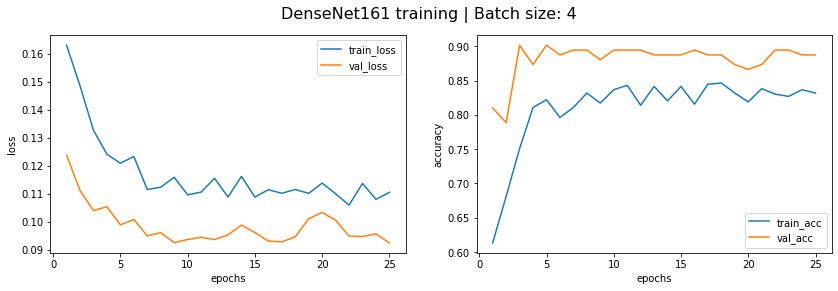


Training results:
	Min val loss 0.0925 was achieved during epoch #25
	Val accuracy during min val loss is 0.8873


In [ ]:

model_densenet161 = models.densenet161(pretrained=True)
for param in model_densenet161.parameters():
    param.requires_grad = False
model_densenet161.classifier = torch.nn.Linear(model_densenet161.classifier.in_features, out_features=2)
model_densenet161 = model_densenet161.to(DEVICE)

densenet161_training_results = training(model=model_densenet161,
                                        model_name='DenseNet161',
                                        num_epochs=num_epochs,
                                        train_dataloader=train_dataloader,
                                        val_dataloader=val_dataloader)

model_densenet161, train_loss_array, train_acc_array, val_loss_array, val_acc_array = densenet161_training_results

min_loss = min(val_loss_array)
min_loss_epoch = val_loss_array.index(min_loss)
min_loss_accuracy = val_acc_array[min_loss_epoch]

visualize_training_results(train_loss_array,
                           val_loss_array,
                           train_acc_array,
                           val_acc_array,
                           num_epochs,
                           model_name="DenseNet161",
                           batch_size=4)
print("\nTraining results:")
print("\tMin val loss {:.4f} was achieved during epoch #{}".format(min_loss, min_loss_epoch + 1))
print("\tVal accuracy during min val loss is {:.4f}".format(min_loss_accuracy))

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 1 | Learning rate: [0.0003]


  4%|▍         | 1/25 [00:38<15:32, 38.85s/it]

	| New lowest val loss for ResNet50: 0.12979884466654817
Epoch: 2 | Learning rate: [0.0003]


  8%|▊         | 2/25 [01:18<14:57, 39.03s/it]

	| New lowest val loss for ResNet50: 0.11634267048096993
Epoch: 3 | Learning rate: [0.0003]


 12%|█▏        | 3/25 [01:57<14:21, 39.18s/it]

	| New lowest val loss for ResNet50: 0.10060675410737455
Epoch: 4 | Learning rate: [9.9e-05]


 16%|█▌        | 4/25 [02:36<13:40, 39.05s/it]

Epoch: 5 | Learning rate: [9.9e-05]


 20%|██        | 5/25 [03:14<12:57, 38.87s/it]

Epoch: 6 | Learning rate: [9.9e-05]


 24%|██▍       | 6/25 [03:53<12:19, 38.90s/it]

	| New lowest val loss for ResNet50: 0.09879222931996198
Epoch: 7 | Learning rate: [3.267e-05]


 28%|██▊       | 7/25 [04:32<11:41, 38.99s/it]

	| New lowest val loss for ResNet50: 0.09797269011467276
Epoch: 8 | Learning rate: [3.267e-05]


 32%|███▏      | 8/25 [05:11<11:02, 39.00s/it]

	| New lowest val loss for ResNet50: 0.0960410381077041
Epoch: 9 | Learning rate: [3.267e-05]


 36%|███▌      | 9/25 [05:50<10:23, 38.96s/it]

Epoch: 10 | Learning rate: [1.0781099999999999e-05]


 40%|████      | 10/25 [06:29<09:45, 39.02s/it]

	| New lowest val loss for ResNet50: 0.09485912706020852
Epoch: 11 | Learning rate: [1.0781099999999999e-05]


 44%|████▍     | 11/25 [07:08<09:05, 38.97s/it]

Epoch: 12 | Learning rate: [1.0781099999999999e-05]


 48%|████▊     | 12/25 [07:47<08:25, 38.88s/it]

Epoch: 13 | Learning rate: [3.557763e-06]


 52%|█████▏    | 13/25 [08:26<07:46, 38.89s/it]

Epoch: 14 | Learning rate: [3.557763e-06]


 56%|█████▌    | 14/25 [09:05<07:07, 38.85s/it]

Epoch: 15 | Learning rate: [3.557763e-06]


 60%|██████    | 15/25 [09:44<06:28, 38.87s/it]

Epoch: 16 | Learning rate: [1.17406179e-06]


 64%|██████▍   | 16/25 [10:22<05:49, 38.83s/it]

Epoch: 17 | Learning rate: [1.17406179e-06]


 68%|██████▊   | 17/25 [11:01<05:10, 38.77s/it]

Epoch: 18 | Learning rate: [1.17406179e-06]


 72%|███████▏  | 18/25 [11:40<04:31, 38.82s/it]

Epoch: 19 | Learning rate: [3.874403907e-07]


 76%|███████▌  | 19/25 [12:19<03:53, 38.87s/it]

Epoch: 20 | Learning rate: [3.874403907e-07]


 80%|████████  | 20/25 [12:58<03:14, 38.83s/it]

Epoch: 21 | Learning rate: [3.874403907e-07]


 84%|████████▍ | 21/25 [13:36<02:35, 38.83s/it]

Epoch: 22 | Learning rate: [1.27855328931e-07]


 88%|████████▊ | 22/25 [14:15<01:56, 38.81s/it]

Epoch: 23 | Learning rate: [1.27855328931e-07]


 92%|█████████▏| 23/25 [14:54<01:17, 38.84s/it]

Epoch: 24 | Learning rate: [1.27855328931e-07]


 96%|█████████▌| 24/25 [15:33<00:38, 38.91s/it]

	| New lowest val loss for ResNet50: 0.09442092441547086
Epoch: 25 | Learning rate: [4.2192258547230004e-08]


100%|██████████| 25/25 [16:12<00:00, 38.90s/it]


Training complete in 16m 12s


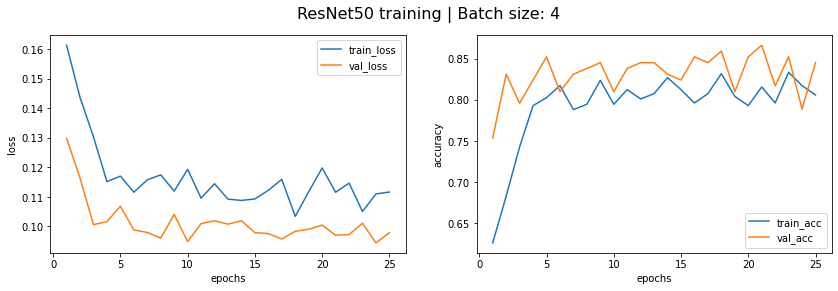


Training results:
	Min val loss 0.0944 was achieved during epoch #24
	Val accuracy during min val loss is 0.7887


In [ ]:
model_resnet50 = models.resnet50(pretrained=True)
for param in model_resnet50.parameters():
    param.requires_grad = False
model_resnet50.fc = torch.nn.Linear(model_resnet50.fc.in_features, 2)
model_resnet50 = model_resnet50.to(DEVICE)

resnet50_training_results = training(model=model_resnet50,
                                      model_name='ResNet50',
                                      num_epochs=num_epochs,
                                      train_dataloader=train_dataloader,
                                      val_dataloader=val_dataloader)

model_resnet50, train_loss_array, train_acc_array, val_loss_array, val_acc_array = resnet50_training_results

min_loss = min(val_loss_array)
min_loss_epoch = val_loss_array.index(min_loss)
min_loss_accuracy = val_acc_array[min_loss_epoch]

visualize_training_results(train_loss_array,
                           val_loss_array,
                           train_acc_array,
                           val_acc_array,
                           num_epochs,
                           model_name="ResNet50",
                           batch_size=4)
print("\nTraining results:")
print("\tMin val loss {:.4f} was achieved during epoch #{}".format(min_loss, min_loss_epoch + 1))
print("\tVal accuracy during min val loss is {:.4f}".format(min_loss_accuracy))

Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth


  0%|          | 0.00/230M [00:00<?, ?B/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 1 | Learning rate: [0.0003]


  4%|▍         | 1/25 [00:51<20:26, 51.11s/it]

	| New lowest val loss for ResNet152: 0.14222807174837085
Epoch: 2 | Learning rate: [0.0003]


  8%|▊         | 2/25 [01:41<19:24, 50.63s/it]

Epoch: 3 | Learning rate: [0.0003]


 12%|█▏        | 3/25 [02:31<18:29, 50.42s/it]

Epoch: 4 | Learning rate: [9.9e-05]


 16%|█▌        | 4/25 [03:21<17:38, 50.40s/it]

Epoch: 5 | Learning rate: [9.9e-05]


 20%|██        | 5/25 [04:12<16:48, 50.43s/it]

Epoch: 6 | Learning rate: [9.9e-05]


 24%|██▍       | 6/25 [05:02<15:55, 50.30s/it]

Epoch: 7 | Learning rate: [3.267e-05]


 28%|██▊       | 7/25 [05:53<15:08, 50.48s/it]

	| New lowest val loss for ResNet152: 0.12324757454260973
Epoch: 8 | Learning rate: [3.267e-05]


 32%|███▏      | 8/25 [06:43<14:16, 50.39s/it]

Epoch: 9 | Learning rate: [3.267e-05]


 36%|███▌      | 9/25 [07:33<13:25, 50.32s/it]

Epoch: 10 | Learning rate: [1.0781099999999999e-05]


 40%|████      | 10/25 [08:23<12:33, 50.25s/it]

Epoch: 11 | Learning rate: [1.0781099999999999e-05]


 44%|████▍     | 11/25 [09:13<11:42, 50.21s/it]

Epoch: 12 | Learning rate: [1.0781099999999999e-05]


 48%|████▊     | 12/25 [10:04<10:52, 50.19s/it]

Epoch: 13 | Learning rate: [3.557763e-06]


 52%|█████▏    | 13/25 [10:53<10:01, 50.09s/it]

Epoch: 14 | Learning rate: [3.557763e-06]


 56%|█████▌    | 14/25 [11:44<09:11, 50.12s/it]

Epoch: 15 | Learning rate: [3.557763e-06]


 60%|██████    | 15/25 [12:34<08:22, 50.24s/it]

Epoch: 16 | Learning rate: [1.17406179e-06]


 64%|██████▍   | 16/25 [13:25<07:33, 50.38s/it]

Epoch: 17 | Learning rate: [1.17406179e-06]


 68%|██████▊   | 17/25 [14:15<06:43, 50.46s/it]

Epoch: 18 | Learning rate: [1.17406179e-06]


 72%|███████▏  | 18/25 [15:07<05:55, 50.81s/it]

Epoch: 19 | Learning rate: [3.874403907e-07]


 76%|███████▌  | 19/25 [15:59<05:07, 51.17s/it]

Epoch: 20 | Learning rate: [3.874403907e-07]


 80%|████████  | 20/25 [16:51<04:17, 51.41s/it]

Epoch: 21 | Learning rate: [3.874403907e-07]


 84%|████████▍ | 21/25 [17:43<03:26, 51.57s/it]

Epoch: 22 | Learning rate: [1.27855328931e-07]


 88%|████████▊ | 22/25 [18:35<02:35, 51.67s/it]

Epoch: 23 | Learning rate: [1.27855328931e-07]


 92%|█████████▏| 23/25 [19:27<01:43, 51.77s/it]

Epoch: 24 | Learning rate: [1.27855328931e-07]


 96%|█████████▌| 24/25 [20:19<00:51, 51.84s/it]

Epoch: 25 | Learning rate: [4.2192258547230004e-08]


100%|██████████| 25/25 [21:11<00:00, 50.85s/it]


Training complete in 21m 11s


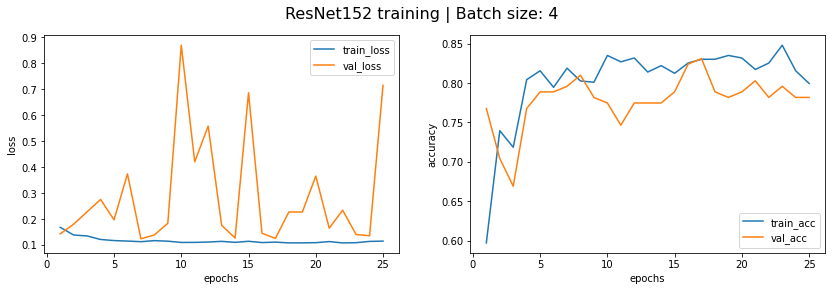


Training results:
	Min val loss 0.1232 was achieved during epoch #7
	Val accuracy during min val loss is 0.7958


In [ ]:
model_resnet152 = models.resnet152(pretrained=True)
for param in model_resnet152.parameters():
    param.requires_grad = False
model_resnet152.fc = torch.nn.Linear(model_resnet152.fc.in_features, 2)
model_resnet152 = model_resnet152.to(DEVICE)

resnet152_training_results = training(model=model_resnet152,
                                      model_name='ResNet152',
                                      num_epochs=num_epochs,
                                      train_dataloader=train_dataloader,
                                      val_dataloader=val_dataloader)

model_resnet152, train_loss_array, train_acc_array, val_loss_array, val_acc_array = resnet152_training_results

min_loss = min(val_loss_array)
min_loss_epoch = val_loss_array.index(min_loss)
min_loss_accuracy = val_acc_array[min_loss_epoch]

visualize_training_results(train_loss_array,
                           val_loss_array,
                           train_acc_array,
                           val_acc_array,
                           num_epochs,
                           model_name="ResNet152",
                           batch_size=4)
print("\nTraining results:")
print("\tMin val loss {:.4f} was achieved during epoch #{}".format(min_loss, min_loss_epoch + 1))
print("\tVal accuracy during min val loss is {:.4f}".format(min_loss_accuracy))

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 1 | Learning rate: [0.0003]


  4%|▍         | 1/25 [00:48<19:29, 48.71s/it]

	| New lowest val loss for VGG16: 0.12666666502474058
Epoch: 2 | Learning rate: [0.0003]


  8%|▊         | 2/25 [01:37<18:36, 48.54s/it]

	| New lowest val loss for VGG16: 0.12276871720145285
Epoch: 3 | Learning rate: [0.0003]


 12%|█▏        | 3/25 [02:25<17:47, 48.54s/it]

	| New lowest val loss for VGG16: 0.11378979023126229
Epoch: 4 | Learning rate: [9.9e-05]


 16%|█▌        | 4/25 [03:14<16:59, 48.54s/it]

	| New lowest val loss for VGG16: 0.11235763308342914
Epoch: 5 | Learning rate: [9.9e-05]


 20%|██        | 5/25 [04:02<16:11, 48.59s/it]

	| New lowest val loss for VGG16: 0.11165895301219024
Epoch: 6 | Learning rate: [9.9e-05]


 24%|██▍       | 6/25 [04:51<15:22, 48.55s/it]

	| New lowest val loss for VGG16: 0.1108747959320604
Epoch: 7 | Learning rate: [3.267e-05]


 28%|██▊       | 7/25 [05:37<14:22, 47.92s/it]

Epoch: 8 | Learning rate: [3.267e-05]


 32%|███▏      | 8/25 [06:26<13:37, 48.10s/it]

	| New lowest val loss for VGG16: 0.10991159331997935
Epoch: 9 | Learning rate: [3.267e-05]


 36%|███▌      | 9/25 [07:13<12:42, 47.65s/it]

Epoch: 10 | Learning rate: [1.0781099999999999e-05]


 40%|████      | 10/25 [07:59<11:50, 47.33s/it]

Epoch: 11 | Learning rate: [1.0781099999999999e-05]


 44%|████▍     | 11/25 [08:46<10:59, 47.10s/it]

Epoch: 12 | Learning rate: [1.0781099999999999e-05]


 48%|████▊     | 12/25 [09:33<10:10, 46.99s/it]

Epoch: 13 | Learning rate: [3.557763e-06]


 52%|█████▏    | 13/25 [10:19<09:22, 46.84s/it]

Epoch: 14 | Learning rate: [3.557763e-06]


 56%|█████▌    | 14/25 [11:05<08:32, 46.61s/it]

Epoch: 15 | Learning rate: [3.557763e-06]


 60%|██████    | 15/25 [11:51<07:44, 46.48s/it]

Epoch: 16 | Learning rate: [1.17406179e-06]


 64%|██████▍   | 16/25 [12:37<06:54, 46.11s/it]

Epoch: 17 | Learning rate: [1.17406179e-06]


 68%|██████▊   | 17/25 [13:21<06:05, 45.63s/it]

Epoch: 18 | Learning rate: [1.17406179e-06]


 72%|███████▏  | 18/25 [14:06<05:17, 45.32s/it]

Epoch: 19 | Learning rate: [3.874403907e-07]


 76%|███████▌  | 19/25 [14:51<04:31, 45.22s/it]

Epoch: 20 | Learning rate: [3.874403907e-07]


 80%|████████  | 20/25 [15:37<03:47, 45.51s/it]

Epoch: 21 | Learning rate: [3.874403907e-07]


 84%|████████▍ | 21/25 [16:23<03:03, 45.82s/it]

Epoch: 22 | Learning rate: [1.27855328931e-07]


 88%|████████▊ | 22/25 [17:10<02:18, 46.08s/it]

Epoch: 23 | Learning rate: [1.27855328931e-07]


 92%|█████████▏| 23/25 [17:57<01:32, 46.26s/it]

Epoch: 24 | Learning rate: [1.27855328931e-07]


 96%|█████████▌| 24/25 [18:43<00:46, 46.39s/it]

Epoch: 25 | Learning rate: [4.2192258547230004e-08]


100%|██████████| 25/25 [19:30<00:00, 46.82s/it]


Training complete in 19m 31s


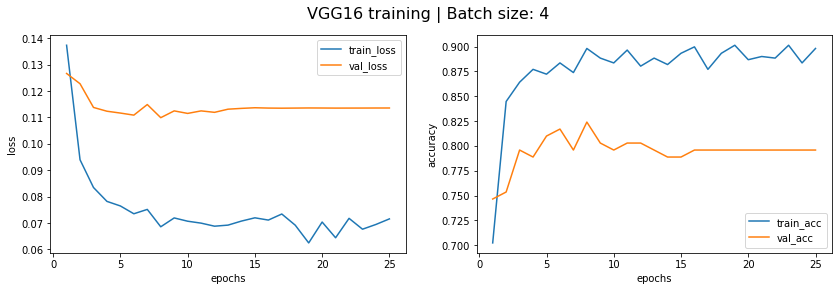


Training results:
	Min val loss 0.1099 was achieved during epoch #8
	Val accuracy during min val loss is 0.8239


In [ ]:
model_vgg16 = models.vgg16(pretrained=True)
for param in model_vgg16.parameters():
    param.requires_grad = False
model_vgg16.classifier[6] = torch.nn.Linear(in_features=model_vgg16.classifier[6].in_features, out_features=2)
model_vgg16 = model_vgg16.to(DEVICE)

vgg16_training_results = training(model=model_vgg16,
                                     model_name='VGG16',
                                     num_epochs=num_epochs,
                                     train_dataloader=train_dataloader,
                                     val_dataloader=val_dataloader)

model_vgg16, train_loss_array, train_acc_array, val_loss_array, val_acc_array = vgg16_training_results

min_loss = min(val_loss_array)
min_loss_epoch = val_loss_array.index(min_loss)
min_loss_accuracy = val_acc_array[min_loss_epoch]

visualize_training_results(train_loss_array,
                           val_loss_array,
                           train_acc_array,
                           val_acc_array,
                           num_epochs,
                           model_name="VGG16",
                           batch_size=4)
print("\nTraining results:")
print("\tMin val loss {:.4f} was achieved during epoch #{}".format(min_loss, min_loss_epoch + 1))
print("\tVal accuracy during min val loss is {:.4f}".format(min_loss_accuracy))

Downloading: "https://download.pytorch.org/models/vgg19_bn-c79401a0.pth" to /root/.cache/torch/hub/checkpoints/vgg19_bn-c79401a0.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 1 | Learning rate: [0.0003]


  4%|▍         | 1/25 [00:52<20:51, 52.15s/it]

	| New lowest val loss for VGG19_bn: 0.12809287242486445
Epoch: 2 | Learning rate: [0.0003]


  8%|▊         | 2/25 [01:44<19:59, 52.16s/it]

	| New lowest val loss for VGG19_bn: 0.09822190201408426
Epoch: 3 | Learning rate: [0.0003]


 12%|█▏        | 3/25 [02:34<18:45, 51.14s/it]

Epoch: 4 | Learning rate: [9.9e-05]


 16%|█▌        | 4/25 [03:25<17:58, 51.36s/it]

	| New lowest val loss for VGG19_bn: 0.09307605684013434
Epoch: 5 | Learning rate: [9.9e-05]


 20%|██        | 5/25 [04:17<17:11, 51.59s/it]

	| New lowest val loss for VGG19_bn: 0.09267711956841006
Epoch: 6 | Learning rate: [9.9e-05]


 24%|██▍       | 6/25 [05:09<16:22, 51.73s/it]

	| New lowest val loss for VGG19_bn: 0.0883615731825711
Epoch: 7 | Learning rate: [3.267e-05]


 28%|██▊       | 7/25 [05:59<15:20, 51.12s/it]

Epoch: 8 | Learning rate: [3.267e-05]


 32%|███▏      | 8/25 [06:49<14:22, 50.71s/it]

Epoch: 9 | Learning rate: [3.267e-05]


 36%|███▌      | 9/25 [07:39<13:26, 50.43s/it]

Epoch: 10 | Learning rate: [1.0781099999999999e-05]


 40%|████      | 10/25 [08:29<12:33, 50.22s/it]

Epoch: 11 | Learning rate: [1.0781099999999999e-05]


 44%|████▍     | 11/25 [09:18<11:40, 50.03s/it]

Epoch: 12 | Learning rate: [1.0781099999999999e-05]


 48%|████▊     | 12/25 [10:08<10:49, 49.96s/it]

Epoch: 13 | Learning rate: [3.557763e-06]


 52%|█████▏    | 13/25 [10:58<09:58, 49.87s/it]

Epoch: 14 | Learning rate: [3.557763e-06]


 56%|█████▌    | 14/25 [11:47<09:07, 49.78s/it]

Epoch: 15 | Learning rate: [3.557763e-06]


 60%|██████    | 15/25 [12:37<08:17, 49.77s/it]

Epoch: 16 | Learning rate: [1.17406179e-06]


 64%|██████▍   | 16/25 [13:27<07:27, 49.73s/it]

Epoch: 17 | Learning rate: [1.17406179e-06]


 68%|██████▊   | 17/25 [14:17<06:37, 49.75s/it]

Epoch: 18 | Learning rate: [1.17406179e-06]


 72%|███████▏  | 18/25 [15:06<05:48, 49.77s/it]

Epoch: 19 | Learning rate: [3.874403907e-07]


 76%|███████▌  | 19/25 [15:56<04:58, 49.73s/it]

Epoch: 20 | Learning rate: [3.874403907e-07]


 80%|████████  | 20/25 [16:45<04:07, 49.55s/it]

Epoch: 21 | Learning rate: [3.874403907e-07]


 84%|████████▍ | 21/25 [17:34<03:17, 49.41s/it]

Epoch: 22 | Learning rate: [1.27855328931e-07]


 88%|████████▊ | 22/25 [18:23<02:28, 49.38s/it]

Epoch: 23 | Learning rate: [1.27855328931e-07]


 92%|█████████▏| 23/25 [19:13<01:38, 49.28s/it]

Epoch: 24 | Learning rate: [1.27855328931e-07]


 96%|█████████▌| 24/25 [20:03<00:49, 49.59s/it]

Epoch: 25 | Learning rate: [4.2192258547230004e-08]


100%|██████████| 25/25 [20:53<00:00, 50.14s/it]


Training complete in 20m 53s


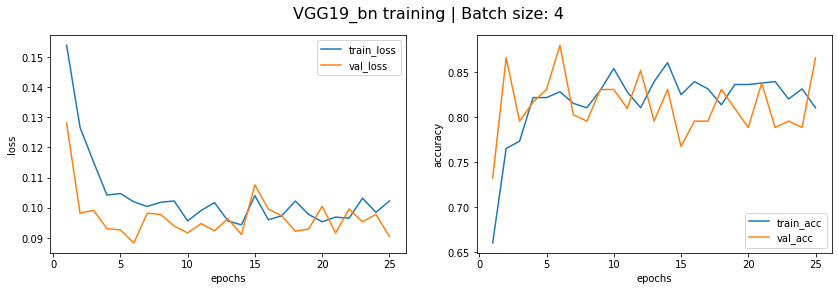


Training results:
	Min val loss 0.0884 was achieved during epoch #6
	Val accuracy during min val loss is 0.8803


In [ ]:
model_vgg19_bn = models.vgg19_bn(pretrained=True)
for param in model_vgg19_bn.parameters():
    param.requires_grad = False
model_vgg19_bn.classifier[6] = torch.nn.Linear(in_features=model_vgg19_bn.classifier[6].in_features, out_features=2)
model_vgg19_bn = model_vgg19_bn.to(DEVICE)

vgg19_bn_training_results = training(model=model_vgg19_bn,
                                     model_name='VGG19_bn',
                                     num_epochs=num_epochs,
                                     train_dataloader=train_dataloader,
                                     val_dataloader=val_dataloader)

model_vgg19_bn, train_loss_array, train_acc_array, val_loss_array, val_acc_array = vgg19_bn_training_results

min_loss = min(val_loss_array)
min_loss_epoch = val_loss_array.index(min_loss)
min_loss_accuracy = val_acc_array[min_loss_epoch]

visualize_training_results(train_loss_array,
                           val_loss_array,
                           train_acc_array,
                           val_acc_array,
                           num_epochs,
                           model_name="VGG19_bn",
                           batch_size=4)
print("\nTraining results:")
print("\tMin val loss {:.4f} was achieved during epoch #{}".format(min_loss, min_loss_epoch + 1))
print("\tVal accuracy during min val loss is {:.4f}".format(min_loss_accuracy))

In [ ]:

class EnsembleModel(nn.Module):   
    def __init__(self, modelA, modelB, modelC, modelD, modelE):
        super(EnsembleModel, self).__init__()
        self.modelA = modelA
        self.modelB = modelB
        self.modelC = modelC
        self.modelD = modelD
        self.modelE = modelE

        # create new classifier
        self.classifier = nn.Linear(2*5, 2)
        
    def forward(self, x):
        x1 = self.modelA(x.clone())
        x1 = x1.view(x1.size(0), -1)
        x2 = self.modelB(x)
        x2 = x2.view(x2.size(0), -1)
        x3 = self.modelC(x)
        x3 = x3.view(x3.size(0), -1)
        x4 = self.modelD(x)
        x4 = x4.view(x4.size(0), -1)
        x5 = self.modelE(x)
        x5 = x5.view(x4.size(0), -1)

        x = torch.cat((x1, x2, x3, x4, x5), dim=1)
        out = self.classifier(x)
        return out
    
ensemble_model = EnsembleModel(model_densenet161, model_resnet50, model_resnet152, model_vgg16, model_vgg19_bn)

for param in ensemble_model.parameters():
    param.requires_grad = False

for param in ensemble_model.classifier.parameters():
    param.requires_grad = True    

ensemble_model = ensemble_model.to(DEVICE)

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 1 | Learning rate: [0.0003]


  4%|▍         | 1/25 [02:18<55:24, 138.51s/it]

	| New lowest val loss for Ensemble: 0.18686740373221922
Epoch: 2 | Learning rate: [0.0003]


  8%|▊         | 2/25 [04:37<53:11, 138.78s/it]

	| New lowest val loss for Ensemble: 0.13594364952033675
Epoch: 3 | Learning rate: [0.0003]


 12%|█▏        | 3/25 [06:56<50:51, 138.69s/it]

	| New lowest val loss for Ensemble: 0.09101682025152193
Epoch: 4 | Learning rate: [9.9e-05]


 16%|█▌        | 4/25 [09:08<47:40, 136.21s/it]

Epoch: 5 | Learning rate: [9.9e-05]


 20%|██        | 5/25 [11:27<45:41, 137.07s/it]

	| New lowest val loss for Ensemble: 0.08914297708952931
Epoch: 6 | Learning rate: [9.9e-05]


 24%|██▍       | 6/25 [13:39<42:51, 135.34s/it]

Epoch: 7 | Learning rate: [3.267e-05]


 28%|██▊       | 7/25 [15:50<40:16, 134.23s/it]

Epoch: 8 | Learning rate: [3.267e-05]


 32%|███▏      | 8/25 [18:02<37:49, 133.49s/it]

Epoch: 9 | Learning rate: [3.267e-05]


 36%|███▌      | 9/25 [20:14<35:28, 133.04s/it]

Epoch: 10 | Learning rate: [1.0781099999999999e-05]


 40%|████      | 10/25 [22:27<33:11, 132.76s/it]

Epoch: 11 | Learning rate: [1.0781099999999999e-05]


 44%|████▍     | 11/25 [24:39<30:56, 132.62s/it]

Epoch: 12 | Learning rate: [1.0781099999999999e-05]


 48%|████▊     | 12/25 [26:57<29:04, 134.18s/it]

	| New lowest val loss for Ensemble: 0.08415057336990263
Epoch: 13 | Learning rate: [3.557763e-06]


 52%|█████▏    | 13/25 [29:09<26:42, 133.51s/it]

Epoch: 14 | Learning rate: [3.557763e-06]


 56%|█████▌    | 14/25 [31:21<24:25, 133.21s/it]

Epoch: 15 | Learning rate: [3.557763e-06]


 60%|██████    | 15/25 [33:34<22:10, 133.02s/it]

Epoch: 16 | Learning rate: [1.17406179e-06]


 64%|██████▍   | 16/25 [35:46<19:55, 132.89s/it]

Epoch: 17 | Learning rate: [1.17406179e-06]


 68%|██████▊   | 17/25 [37:58<17:41, 132.65s/it]

Epoch: 18 | Learning rate: [1.17406179e-06]


 72%|███████▏  | 18/25 [40:11<15:28, 132.59s/it]

Epoch: 19 | Learning rate: [3.874403907e-07]


 76%|███████▌  | 19/25 [42:23<13:15, 132.59s/it]

Epoch: 20 | Learning rate: [3.874403907e-07]


 80%|████████  | 20/25 [44:42<11:12, 134.48s/it]

	| New lowest val loss for Ensemble: 0.08399552497750437
Epoch: 21 | Learning rate: [3.874403907e-07]


 84%|████████▍ | 21/25 [46:55<08:55, 133.96s/it]

Epoch: 22 | Learning rate: [1.27855328931e-07]


 88%|████████▊ | 22/25 [49:07<06:40, 133.50s/it]

Epoch: 23 | Learning rate: [1.27855328931e-07]


 92%|█████████▏| 23/25 [51:20<04:26, 133.17s/it]

Epoch: 24 | Learning rate: [1.27855328931e-07]


 96%|█████████▌| 24/25 [53:33<02:13, 133.03s/it]

Epoch: 25 | Learning rate: [4.2192258547230004e-08]


100%|██████████| 25/25 [55:44<00:00, 133.79s/it]


Training complete in 55m 45s


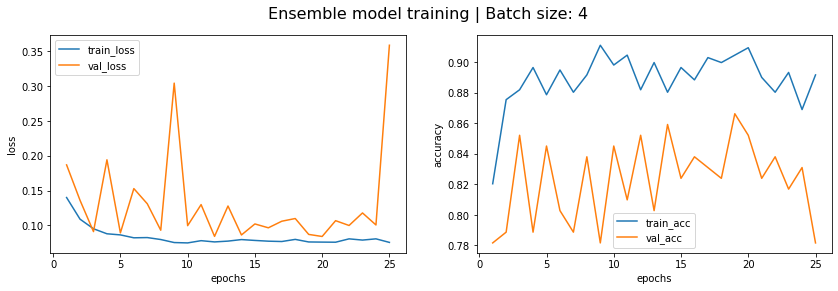


Training results:
	Min val loss 0.0840 was achieved during iteration #20
	Val accuracy during min val loss is 0.8521


In [ ]:
ensemble_training_results = training(model=ensemble_model,
                                     model_name='Ensemble',
                                     num_epochs=25,
                                     train_dataloader=train_dataloader,
                                     val_dataloader=val_dataloader)

ensemble_model, train_loss_array, train_acc_array, val_loss_array, val_acc_array = ensemble_training_results

min_loss = min(val_loss_array)
min_loss_iteration = val_loss_array.index(min_loss)
min_loss_accuracy = val_acc_array[min_loss_iteration]

visualize_training_results(train_loss_array,
                           val_loss_array,
                           train_acc_array,
                           val_acc_array,
                           num_epochs=25,
                           model_name="Ensemble model",
                           batch_size=4)
print("\nTraining results:")
print("\tMin val loss {:.4f} was achieved during iteration #{}".format(min_loss, min_loss_iteration + 1))
print("\tVal accuracy during min val loss is {:.4f}".format(min_loss_accuracy))

In [ ]:
test_dataloader = DataLoader(test_dataset, batch_size=4, shuffle=False)

all_preds = []
all_files = []

ensemble_model.eval()
with torch.no_grad():
    for samples, f_names in tqdm(test_dataloader):
        samples = samples.to(DEVICE)
        outputs = ensemble_model(samples)
        preds = outputs.argmax(dim=1)
        all_preds.extend(preds.tolist())
        all_files.extend(f_names)

all_filenames = [f_name[30:] for f_name in all_files]
all_preds_decoded = encoder_labels.inverse_transform(all_preds)

ensemble_df = pd.DataFrame(list(zip(all_filenames, all_preds_decoded)), columns =['File', 'Prediction'])
ensemble_df.head(10)

100%|██████████| 15/15 [00:23<00:00,  1.57s/it]


,File,Prediction
0,DS440-Team1)/Data/Data_collection2/animal_stat...,Violation
1,DS440-Team1)/Data/Data_collection2/animal_stat...,Non_Violation
2,DS440-Team1)/Data/Data_collection2/animal_stat...,Non_Violation
3,DS440-Team1)/Data/Data_collection2/animal_stat...,Non_Violation
4,DS440-Team1)/Data/Data_collection2/animal_stat...,Non_Violation
5,DS440-Team1)/Data/Data_collection2/animal_stat...,Non_Violation
6,DS440-Team1)/Data/Data_collection2/animal_stat...,Violation
7,DS440-Team1)/Data/Data_collection2/animal_stat...,Non_Violation
8,DS440-Team1)/Data/Data_collection2/animal_stat...,Non_Violation
9,DS440-Team1)/Data/Data_collection2/animal_stat...,Violation


In [ ]:
ensemble_df

,File,Prediction
0,DS440-Team1)/Data/Data_collection2/animal_stat...,Violation
1,DS440-Team1)/Data/Data_collection2/animal_stat...,Non_Violation
2,DS440-Team1)/Data/Data_collection2/animal_stat...,Non_Violation
3,DS440-Team1)/Data/Data_collection2/animal_stat...,Non_Violation
4,DS440-Team1)/Data/Data_collection2/animal_stat...,Non_Violation
5,DS440-Team1)/Data/Data_collection2/animal_stat...,Non_Violation
6,DS440-Team1)/Data/Data_collection2/animal_stat...,Violation
7,DS440-Team1)/Data/Data_collection2/animal_stat...,Non_Violation
8,DS440-Team1)/Data/Data_collection2/animal_stat...,Non_Violation
9,DS440-Team1)/Data/Data_collection2/animal_stat...,Violation


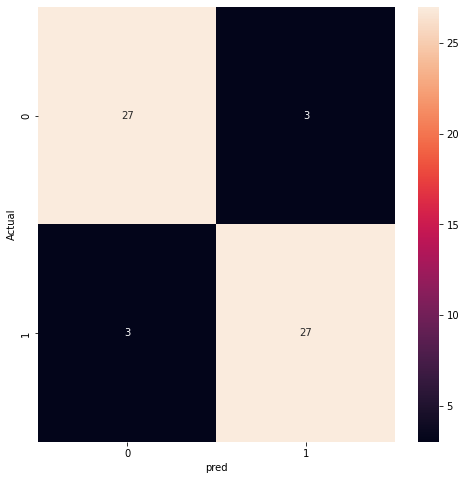

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
conf_mat = confusion_matrix(labels_test, all_preds_decoded)
fig, ax = plt.subplots(figsize = (8,8))
sns.heatmap(conf_mat, annot = True, fmt = 'd')
plt.ylabel('Actual')
plt.xlabel('pred')
plt.show()

In [ ]:
from sklearn.metrics import classification_report
matrix = classification_report(labels_test, all_preds_decoded,target_names=labels)
print('Classification report : \n',matrix)

Classification report : 
                precision    recall  f1-score   support

    Violation       0.90      0.90      0.90        30
Non_Violation       0.90      0.90      0.90        30

     accuracy                           0.90        60
    macro avg       0.90      0.90      0.90        60
 weighted avg       0.90      0.90      0.90        60



In [ ]:
model_save_name = 'ensembleclassifier2.pt'
path = F"/content/gdrive/My Drive/{model_save_name}" 
torch.save(ensemble_model.state_dict(), path)

In [ ]:
model_save_name = 'ensembleclassifier2.pt'
path = F"/content/gdrive/My Drive/{model_save_name}"
ensemble_model.load_state_dict(torch.load(path))

<All keys matched successfully>